# GPSO optimisation example with saving the model output

So in the real world, usually you want to, say, optimise the parameters of the model AND save the model results, right? So after the optimisation you can check plethora of other stuff on your model.
Don't worry, we got your back!

In [1]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
from shutil import rmtree
import logging
from gpflow.utilities import print_summary

from gpso.param_space import ParameterSpace
from gpso.optimisation import GPSOptimiser
from gpso.utils import set_logger, make_dirs
from gpso.saving_helper import TableSaver, table_reader

plt.style.use("seaborn-poster")

again, objective function and parameter space are without change

In [2]:
# define objective function - compare with paper Fig. 2
def obj(point, offset=0.0, rotate=True):
    x, y = point
    if rotate:
        ct = np.cos(np.pi / 4)
        st = np.sin(np.pi / 4)
        xn = ct * x + st * y
        yn = ct * y - st * x
        x = xn
        y = yn
    return (
        3 * (1 - x) ** 2.0 * np.exp(-(x ** 2) - (y + 1) ** 2)
        - 10 * (x / 5.0 - x ** 3 - y ** 5) * np.exp(-(x ** 2) - y ** 2)
        - 1 / 3 * np.exp(-((x + 1) ** 2) - y ** 2)
        - offset
    )


# bounds of the parameters we will optimise
x_bounds = [-3, 5]
y_bounds = [-3, 3]
# number of points per dimension for plotting
N_POINTS = 120

In [3]:
space = ParameterSpace(
    parameter_names=["x", "y"], parameter_bounds=[x_bounds, y_bounds]
)

### Saving the output

It's easy - just initialise the `TableSaver` with filename of HDF file and we are good! And yes, the objective function now needs to return **both**: the model results and score which we are optimising

In [4]:
output_dir = "output"
make_dirs(output_dir)

# init saver
saver = TableSaver(os.path.join(output_dir, "results.h5"))

In [5]:
def obj_w_return(point, offset=0.0, rotate=True):
    # we re-use the original objective function
    score = obj(point, offset, rotate)
    # and create dummy timeseries - 100 samples long with 2 features
    np.random.seed(int(np.abs(point[0])))
    timeseries = np.random.rand(100, 2)
    # return first timeseries, then score
    return timeseries, score

In [6]:
opt = GPSOptimiser(
    parameter_space=space,
    exploration_method="tree",
    exploration_depth=5,
    update_cycle=1,
    budget=50,
    stopping_condition="evaluations",
    gp_lik_sigma=1.0e-3,
    n_workers=4,
    saver=saver,
)

In [7]:
# log_level INFO: reasonable amount of information on what is happening
# log_level DEBUG: a lot of information on what is happening
set_logger(log_level=logging.INFO)
# run vanilla, with default initialisation and just 1 repetition of objective function (since it's deterministic...)
best_point = opt.run(obj_w_return)

[2020-03-20 20:11:21] INFO: Starting 2-dimensional optimisation with budget of 50 objective function evaluations...
[2020-03-20 20:11:21] INFO: Sampling 2 vertices per dimension within L1 ball of 0.25 of the domain size radius in normalised coordinates using 4 worker(s)...
[2020-03-20 20:11:21] INFO: Update step: retraining GP model and updating scores...
[2020-03-20 20:11:24] INFO: Exploration step: sampling children in the ternary tree...
[2020-03-20 20:11:24] INFO: Selecting step: evaluating best leaves...
[2020-03-20 20:11:24] INFO: Update step: retraining GP model and updating scores...
[2020-03-20 20:11:24] INFO: After 1th iteration: 
	 number of obj. func. evaluations: 6 
	 highest score: 2.019346080880167 
	 highest UCB: 0.546413730058452
[2020-03-20 20:11:24] INFO: Exploration step: sampling children in the ternary tree...
[2020-03-20 20:11:24] INFO: Selecting step: evaluating best leaves...
[2020-03-20 20:11:24] INFO: Update step: retraining GP model and updating scores...
[2

In [8]:
# WOHOOO, check the best point
print(best_point)
# and print summary of our trained GPR model
print_summary(opt.gp_surr.gpr_model, fmt="notebook")

GPPoint(normed_coord=array([0.23662551, 0.68518519]), score_mu=8.102201204076508, score_sigma=0.0, score_ucb=0.0, label=<PointLabels.evaluated: 1>)


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,,,True,(),float64,0.19149976301992186
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.163835951715155
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.12871433]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0482618379448408e-06


In [9]:
# do not forget to close the saver
saver.close()

### After

so yes, the results are the same, nice...

but what about our saved timeseries?

In [10]:
# read the data
results, scores, parameters, extras = table_reader(
    os.path.join(output_dir, "results.h5")
)

[2020-03-20 20:11:34] INFO: Loading output/results.h5...


All returned objects is a list as per run of the model.
* `results` - list of actual results, i.e. dummy timeseries in our case
* `scores` - list of scores per run
* `parameters` - list of parameters per run
* `extras` - here the additional data is stored as a dictionary passed to the `TableSaver` at the initialisation, useful for storing other parameters of your model against which you are not optimising, but it's good to know what are they

[array(8.07790009)]
{'x': array(-1.17283951), 'y': array(1.11111111)}
(100, 2)
None


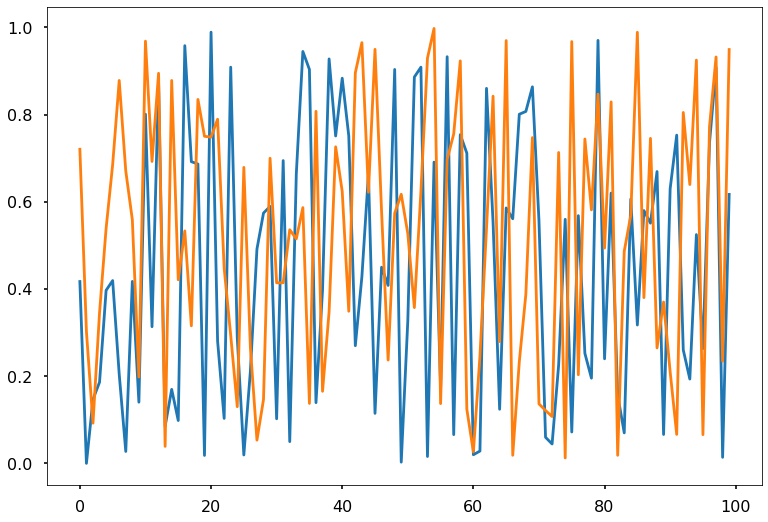

In [11]:
# lets take an example run - 47th, i.e. 46 in pythonic counting
run_no = 46
# check the score
print(scores[run_no])
# show parameters
print(parameters[run_no])
# get the timeseries and plot them
ts = results[run_no]
print(ts[0].shape)
plt.plot(ts[0])
# but it's random data, so...
print(extras)

In [12]:
# cleaning - run after you check the results!
rmtree(output_dir)